In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from pathlib import Path
import trimesh
from tqdm import tqdm
# import pyrender
# os.environ['PYOPENGL_PLATFORM'] = 'egl'
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
p = Path("pti_out/easy-khair-180-gpc0.8-trans10-025000.pkl/PTI_render/")

In [3]:
import trimesh

In [4]:
mesh = trimesh.load(p / 'post_mesh' / 'mesh.obj')
mesh.invert()

In [6]:
import cv2
vidcap = cv2.VideoCapture(str(p / 'post.mp4'))
success,image = vidcap.read()
count = 0
images = []
while success:
    images.append(image)
    success,image = vidcap.read()
    count += 1

In [ ]:
images = np.stack(images)

In [7]:
all_c = np.load(p / 'post_c.npy')

In [8]:
vertices = np.asarray(mesh.vertices)
faces = np.asarray(mesh.faces)

In [9]:
R = all_c[:, :16].reshape(-1, 4, 4)
K = all_c[:, 16:].reshape(-1, 3, 3)

# From minimal pytorch3d example

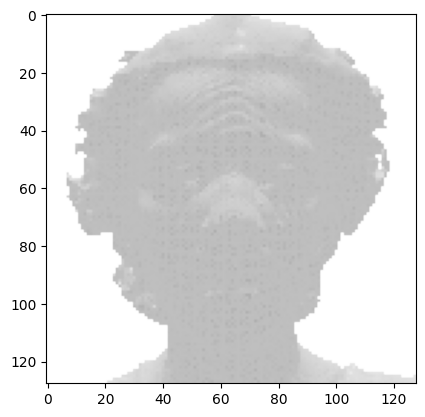

In [42]:
import torch
from pytorch3d.renderer import look_at_view_transform, RasterizationSettings, MeshRenderer, MeshRasterizer, SoftPhongShader, FoVPerspectiveCameras, TexturesVertex, rasterize_meshes
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere

device = torch.device("cuda:0")

# Initialize an ico_sphere mesh and clone to batch size of 10
mesh_pt3d = Meshes(verts=torch.from_numpy(mesh.vertices).float()[None], faces=torch.from_numpy(mesh.faces).long()[None], textures=TexturesVertex(torch.ones(mesh.vertices.shape)[None])).to(device)
# mesh_pt3d = ico_sphere(4, device=device)
# mesh.textures = TexturesVertex(torch.ones_like(mesh.verts_padded()))
# mesh.scale_verts_(0.005)

# Initialize a single camera with given parameters
# R, T = look_at_view_transform(1.0, 0, 0)  
w2c = torch.linalg.inv(torch.from_numpy(R).float())
cameras = FoVPerspectiveCameras(
    R=w2c[:1, :3, :3], 
    T=w2c[:1, :3, 3], 
    fov = np.arctan(1 / K[0, 0, 0]),
    degrees=False,
    device=device
)

# Define the settings for rasterization and shading
raster_settings = RasterizationSettings(image_size=128)
shader = SoftPhongShader(device=device, cameras=cameras)

# Create a renderer by composing a rasterizer and a shader
renderer = MeshRenderer(rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings), shader=shader)

# Render the mesh
image = renderer(mesh_pt3d)
plt.imshow(image.cpu().numpy()[0][::-1])

# From minimal pytorch3d rasterize_meshes example

In [14]:
import torch
from pytorch3d.renderer import look_at_view_transform, RasterizationSettings, MeshRenderer, MeshRasterizer, SoftPhongShader, PerspectiveCameras, TexturesVertex, rasterize_meshes
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere

H = W = 128
idx = 50

device = torch.device("cuda:0")

if type(R) is np.ndarray:
    R, K = torch.from_numpy(R).float(), torch.from_numpy(K).float()
    K[:, :2] *= torch.tensor([W, H]).to(K)[..., None]
# Initialize an ico_sphere mesh and clone to batch size of 10
mesh_pt3d = Meshes(verts=torch.from_numpy(mesh.vertices).float()[None], faces=torch.from_numpy(mesh.faces).long()[None], textures=TexturesVertex(torch.ones(mesh.vertices.shape)[None])).to(device)
# mesh_pt3d = ico_sphere(3, device=devce)
# mesh_pt3d.textures = TexturesVertex(torch.ones_like(mesh_pt3d.verts_padded()))

# Initialize a single camera with given parameters
# R, T = look_at_view_transform(1, 0, 0)
w2c = torch.linalg.inv(R)

f = torch.stack((K[idx: idx + 1, 0, 0], K[idx: idx + 1, 1, 1]), dim=-1)
principal_point = torch.stack([K[idx: idx + 1, 0, 2], K[idx: idx + 1, 1, 2]], dim=1)
img_size = torch.tensor([[H, W]], dtype=torch.int, device=device)
cameras = PerspectiveCameras(
    R=w2c[idx: idx + 1, :3, :3],
    T=w2c[idx: idx + 1, :3, 3],
    principal_point = principal_point,
    focal_length = f,
    image_size=img_size,
    device=device,
    in_ndc=False
)

In [15]:
verts_world = mesh_pt3d.verts_padded()
verts_view = cameras.get_world_to_view_transform().transform_points(
    verts_world
)
projection_trafo = cameras.get_projection_transform().compose(
    cameras.get_ndc_camera_transform()
)
verts_ndc = projection_trafo.transform_points(verts_view)
verts_ndc[..., 2] = verts_view[..., 2]
meshes_ndc = mesh_pt3d.update_padded(new_verts_padded=verts_ndc)

In [16]:
fragments = rasterize_meshes(
    meshes_ndc,
    image_size=128,
    faces_per_pixel=1,
    cull_backfaces=True
)

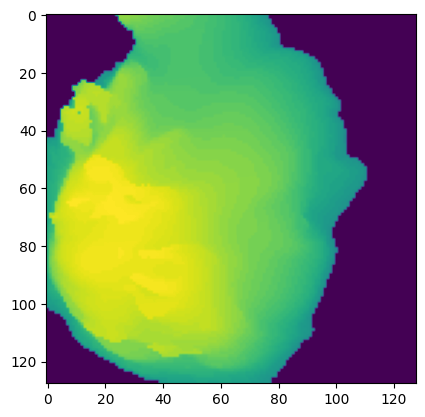

In [17]:
plt.imshow(fragments[0][0, ..., 0].cpu().numpy())

# From minimal pyrender example

In [ ]:
H = W = 400
def initialize():
    m = pyrender.Mesh.from_trimesh(mesh)
    scene = pyrender.Scene()
    scene.add(m)
    r = pyrender.OffscreenRenderer(400, 400)
    return scene, r

def render(scene, r):
    color, depth = r.render(scene)
    return color, depth



renders = []
for i in tqdm(range(len(R))):
    scene, r = initialize()
    for node in scene.get_nodes():
        if node.camera is not None or node.light is not None:
            scene.remove_node(node)
        
    camera = pyrender.IntrinsicsCamera(fx = K[i, 0, 0] * W, fy = K[i, 1, 1] * H, cx = K[i, 0, 2] * W, cy = K[i, 1, 2] * H)
    c2w = R[i].copy()
    c2w[:3, 2] *= -1
    scene.add(camera, pose=c2w)
    light = pyrender.SpotLight(color=np.ones(3), intensity=3.0,
                            innerConeAngle=np.pi/16.0,
                            outerConeAngle=np.pi/6.0)
    scene.add(light, pose=c2w)
    renders.append(render(scene, r))
    r.delete()

plt.figure()
plt.subplot(1,2,1)
plt.title("RGB")
plt.imshow(color)
plt.subplot(1,2,2)
plt.title("Depth")
plt.imshow(depth, cmap=plt.cm.gray_r)
plt.show()

# Visualizations

In [ ]:
from vis import VideoGrid
from IPython.display import HTML

video_grid = VideoGrid(rows=1, cols=1, frame_num=len(R), fps=1, figsize=(5, 5))
# video_grid.set_3d_projection(0, 0, vertical_axis='y')

# video_grid.add_cameras(0, 0, np.linalg.inv(R), focal_length = K[0, 0, 0], edge_length=.4)
# video_grid.add_points(0, 0, vertices[None, ::100].repeat(len(R), 0), plot_kwargs=dict(s=0.01))
video_grid.add_video(0, 0, [image for image, depth in renders])
anim = video_grid.animate()
plt.close()
HTML(anim.to_jshtml())